## Inventory Management

In modern business environment, the company needs more significant efforts to reduce the operating cost and also increase customer satisfaction. Inventory has significant role to satisfy the customer demand hence, it becomes important asset for any organization.Therefore, it should be managed effectively and efficiently to minimize total cost and to satisfy the customer’s requirement. In any real condition, inventory management faces barriers in the form of a tradeoff between minimizing total cost and maximizing service level. Therefore, choosing the correct inventory policy that can be applied in industry now becomes essential to management.

In this project, we use periodic review model and continous review model to determine the optimal policy of Product1 inventory by examining expected revenues in different sceanarios using Monte Carlo simulation and Optimization tools. 

All of the graphs and code can be found in the [MBAN GitHub repository](https://github.com/Master-of-Business-Analytics/Code_repository/tree/master/Inventory%20managment), feel free to download it and modify the numbers for your use case.


In [121]:
#load packages 

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
import operator
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from mpl_toolkits.mplot3d import Axes3D



## Input sales  and product data

To mathematically model this stochastic demand, the sales information of the product for the last 12 months is captured.

In [3]:
#Read in the product information
summary = pd.read_csv('summary_stats.csv')
df = pd.read_excel('XYZ-1.xlsx', 'Data')
demand = df[6:]

Text(0.5, 1.0, 'Histogram of past product sales ')

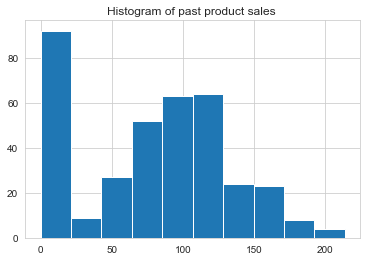

In [4]:
demand[1].hist()
plt.title('Histogram of past product sales ')

Based on the past year sales, the diagram above is the histogram of the demand distribution of the product. The summary table provides operational  and cost data with regards to the supply of product 1. 

 ### Summary Table
 
 Purchase Cost  | Lead Time |Size|Selling price|Starting Stock|Mean| Std Dev|Co|Ch|Probability|Demand_lead
:------------- |------------|----|-------------|--------------|----|--------|--|--|-----------|-----------
 12       | 9|0.57|16.1|2750|103.5|37.32|1000|20|0.76|705

 The summary table provides: 
 
1. Purchase cost of product 1

2. Lead time: Time it takes to receive product 1 after an order. has been made

3. Size: Size of product 1

4. Selling price of product 1

5. Starting stock : Inventory level at begining of the year or start period

6. Mean: Mean Daily sales

7. Standard Deviation of daily sales from the mean

8. Cost of ordering (Co): Administrative cost of ordering product 1 from manufacturer

9. Holding cost (Ch): Warehouse cost for each product

10. Probability : Probability of placing an order on any given day. This can be calculated by dividing the number of orders last year by the number of working days.

11. Demand during leadtime (Demand_lead): This is calculated by multiplying the mean daily, probability of sales and the lead time

In [5]:
# Assigning Variables to be used in project
unit_cost = summary['Purchase Cost']
lead_time = summary['Lead Time']
size = summary['Size']
selling_price = summary['Selling Price']
holding_cost = summary['Ch']
order_cost = summary['Co']
probability = summary['Probability']
starting_stock = summary['Starting Stock']
demand_lead = summary['Demand_lead']

mean = np.mean([np.log(j) for j in demand[demand[1] > 0][1]]) # log mean of past sales
sd = np.std([np.log(j) for j in demand[demand[1] > 0][1]])#log Standard deviation of past sales

## Periodic Review

The periodic review model is one of the inventory policies that reviews physical inventory at specific interval of time and orders the quantity order as many as the maximum level of inventory.

The Monte Carlo technique was used to simulate the daily demand of each product in the store. The probability that the product is sold on that day is calculated by using the past sales data. For example, for Product 1 the expected proportion is 0.76 which means product 1 was sold 76 percent of 365 days that the store was open.

The function below simulates the possibility that there is a sale  using the product's probability of sale. And if there is a sale, then the demand follows a log-normal distribution. 

In [6]:
# Creating a function that allocates the demand  if there is a purchase
# This function is included later

def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)              #chose a random number between 1 and 0
    if random_num > probability:                      #if number is more than probability then there is no sale
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))
    #demand follows a log-normal distribution using mean and sd of the previous year's demand.

## Simulating the demand and calculating profit

A Monte Carlo simulation is conducted to simulate the behaviour of demand and the calculation of annual expected profit for product1. In the simulation, the algorithm iterates through each day trying to capture the inventory level which changes based on the daily demand for the product 1. 

We assume that the review period is 30 days and the maximum stock that can be held in the warehouse is M = 2170.

The logic of the algorithm is as follows:

* If the sales can be completely serviced by the current inventory level — the inventory level is reduced by the sales amount and number of units sold on that day increments.

* If the demand cannot be serviced completely by the inventory level — the inventory on hand would be the number of units sold on that day

In order to model the Periodic Review policy, the algorithm keeps track of the current day in the year. If the day of the year is equal to the review period, then the order is placed to replenish the stock to an order up-to quantity M. This value is the decision variable and is passed as an input to the algorithm. After the lead time has passed for that particular product, the inventory is updated by the order quantity that was placed. This is done for a duration of 365 days.

In [82]:
# Define Monte Carlo Simulation to imitate a periodic review model 

            
def pr_monte_carlo(M,review_period):
    inventory = (summary['Starting Stock']).values.item()
    lead_time = summary['Lead Time']
    probability = summary['Probability']
    demand_lead = summary['Demand_lead']

    mean = np.mean([np.log(j) for j in demand[demand[1] > 0][1]]) # log mean of past sales
    sd = np.std([np.log(j) for j in demand[demand[1] > 0][1]])
    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability.all())
        day_demand = round(day_demand,0)
        
        #used to determine if there is a sale and what the demand would be
        data['daily_demand'].append(day_demand)
        if day % review_period == 0: 
            #check if the day to place order
            q = M - inventory + demand_lead # quantity to be ordered
            data['orders'].append(round(q,0))
            
            order_placed = True
            
        if order_placed:
            counter += 1
             # count days after the order has been made
        
        if counter == (lead_time.values.item()):
            # update inventory when product has been received from manufacturer
            inventory += q
            order_placed = False #reset variable
            counter = 0 #reset variable
            
        inv_gap = inventory - day_demand
        
        if inv_gap.item() >= 0: #check if inventory is enough to satisfy demand
            data['units_sold'].append(day_demand)
            inventory -= day_demand #reduce inventory by daily demand
        else:
            data['units_sold'].append(round(inventory,0))
            lost_sales = day_demand - inventory
            data['units_lost'].append(round(lost_sales,0))
            inventory = 0
            stock_out += 1

        data['inv_level'].append(round(inventory,0))

    return data

#### To simplify the problem, we look at only one instance

In [76]:
df1 = pr_monte_carlo(M=2000,review_period=30)
#Assuming order up-to quantity M and review period is 30 days

df= pd.DataFrame.from_dict(df1['inv_level'])# convert inventory level from list to a dataframe for easy ploting


The Graph below illustrates the inventory level using one instance of the simulation. 

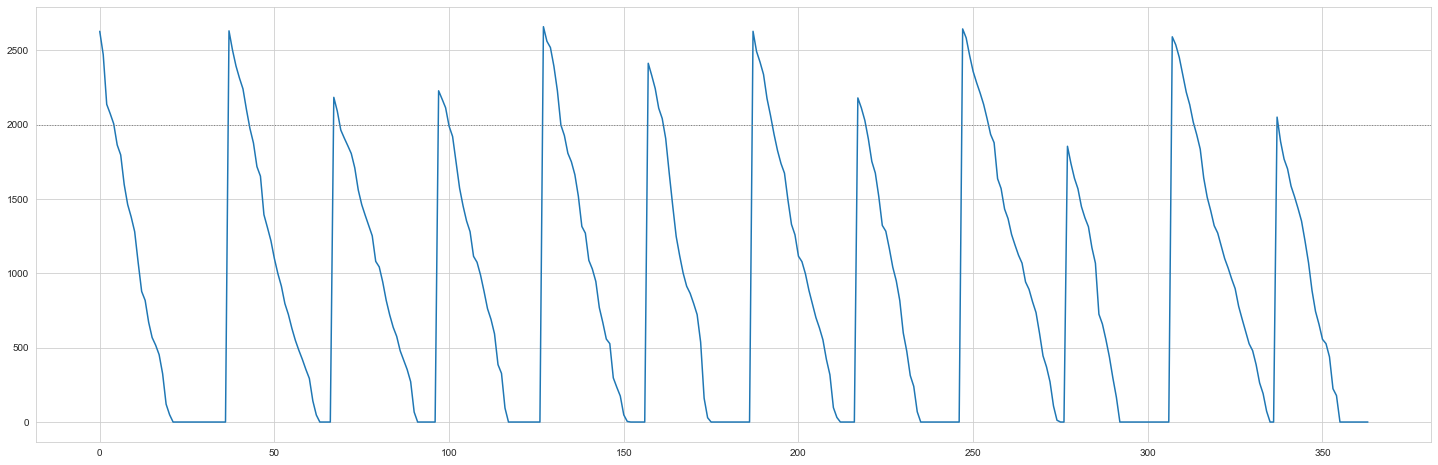

In [77]:

plt.figure(figsize=(25,8))
plt.plot(df1['inv_level'])
plt.axhline(2000, linewidth=1, color="grey", linestyle=":")
plt.show()

In [78]:
#number of orders

len(df1['orders'])

12

To determine the profit the store would have made for that year, all the units that were sold are multiplied by the products selling price to calculate revenue.
The costs are broken down into three components,
### 1. Product costs, 
Product costs are calculated by multiplying the unit costs of each product to the aggregation of the units ordered.
### 2. Ordering costs
The ordering costs are calculated by multiplying the number of times in that year an order was placed to the individual cost of ordering for that product. The inventory levels for each day of the year were aggregated to indicate how much stock was held throughout the duration of the year.
### 3. Holding costs.
The holdings costs were then calculated by multiplying the amount of stock held with the unit size of the product and the daily cost of holding a unit.

In [79]:
#function to calculate profit
def calculate_profit(data):
    days = 365
    unit_cost = summary['Purchase Cost']
    size = summary['Size']
    selling_price = summary['Selling Price']
    holding_cost = summary['Ch']
    order_cost = summary['Co']

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size * (1 / days)
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit[0]

 This simulation was carried out 100 times to give multiple realizations of profit and proportions of lost orders for each time. These results were used to plot a histogram and calculate the mean and standard deviation of profit and the proportion of lost orders for that particular order up-to point (M). The figure below is one such simulation for Product 1 with the order up-to quantity to be 2000
            

In [92]:
#function to replicate the previous instance 100 times 

def mc_simulation( M, num_simulations):
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = pr_monte_carlo(M, review_period=30)
        # Calculating the profit
        profit = calculate_profit(data)
        profit_list.append(round(profit,0))
        # Calculating the orders lost
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(round((unsold_orders/total_demand),2))

    return profit_list, orders_lost_list

    

In [93]:
#Using the simulation to obtain the expected profit 
p_list, o_list = mc_simulation(2000, 100)        

#creating 100 simulations 

In [94]:
print([np.mean(p_list),np.mean(o_list)])


[104252.51, 0.21389999999999998]


Text(0.5, 1.02, 'Profit Distribution: Mean = 98,002 ')

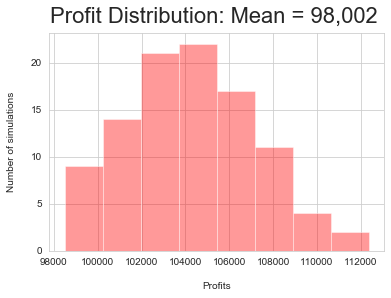

In [95]:
sns.distplot(
    p_list,
    kde=False,
    color='red'
)
plt.xlabel("Profits", labelpad=15)
plt.ylabel("Number of simulations", labelpad=15)
plt.title("Profit Distribution: Mean = 104,252 ", y=1.02, fontsize=22)


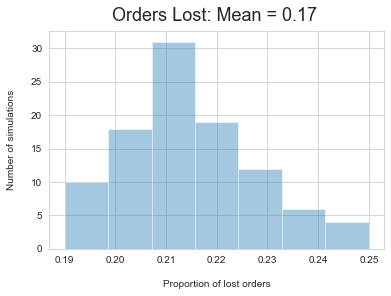

In [96]:
sns.distplot(
    o_list,
    kde=False
)

plt.xlabel("Proportion of lost orders", labelpad=15)
plt.ylabel("Number of simulations", labelpad=15)
plt.title("Orders Lost: Mean = 0.21 ", y=1.02, fontsize=18)
plt.show()

## Profit Optimization in Periodic Review Model

The model can provide answers to the following question,
1. What is the expected profits and whats expected percentage of lost sales? 
2. What should be the M = order up to quantity, that would ensure the highest expected revenue ?

The second question can be answered by repeating this exercise for a range of values of M to determine the value that gives us the highest expected profit. 

In the the model below, we simulated the results for a range of values between 2200 to 4000. 

In [106]:
#Function to vary M to calculate mean profit and 
def periodic_review(low, high, step=50):
    m_range = [i for i in range(low, high, step)]
    review_dict = {}

    for M in m_range:
        p_list, o_list = mc_simulation(M,100)
        review_dict[M] = (np.mean(p_list), np.std(p_list), np.mean(o_list))

    return review_dict

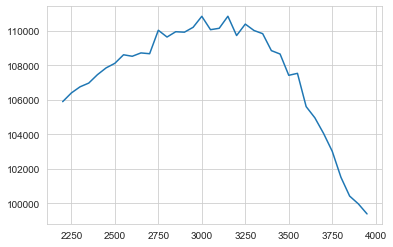

In [108]:
review = periodic_review(2200, 4000)
xx = [i for i in review.keys()]
yy = []

for val in review.values():
    yy.append(val[0])

plt.plot(xx, yy)
plt.show()

This gave an optimum expected profit of $110,846 for the order up-to point of 3150.

In [109]:
# creating a dataframe with all the results
idx = ['Order-point M', 'Expected Profit', 'Profit Standard Deviation', 'Proportion of Lost Orders']

prod_review_1 = max(review.items(), key=operator.itemgetter(1))

df_product_review = pd.DataFrame(
    {'Product 1': [prod_review_1[0], prod_review_1[1][0], prod_review_1[1][1], prod_review_1[1][2]]})

df_product_review = df_product_review.set_index(pd.Index(idx))
df_product_review

,Product 1
Order-point M,3150.000000
Expected Profit,110846.690000
Profit Standard Deviation,3236.885539
Proportion of Lost Orders,0.061800


## Continuous Review Model

In the Continuous review model, the same quantity of items are ordered in each order. The order frequency varies in continuous systems because the inventory is monitored and orders are placed when items reach a particular level.

Because demand is probabilistic, the time the reorder point will be reached, the time between orders, and the time the order of Q units will arrive in inventory cannot be determined in advance. The inventory decreases at a nonconstant rate based on the probabilistic demand and a new order is placed whenever the reorder point is reached. At times, the order quantity will arrive before inventory reaches zero. However, at other times, higher demand will cause a stock-out before a new order is received.

In this policy, the distributor has the ability to check on the inventory regularly and determine at which point they want to place an order (i.e. reorder point (r)). The distributor can also specify how much they want to order each time (i.e. order quantity (q)).

The logic in the Monte Carlo simulation is updated for the Continuous Review policy.


In [110]:

def cc_monte_carlo(q, r):

    mean = np.mean([np.log(j) for j in demand[demand[1] > 0][1]]) # log mean of past sales
    sd = np.std([np.log(j) for j in demand[demand[1] > 0][1]])
    inventory = (summary['Starting Stock']).values.item()
    lead_time = summary['Lead Time']
    probability = summary['Probability']


    order_placed = False
    order_time = 0
    stock_out = 0
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    
    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability.all())
        day_demand = round(day_demand,0)
        
        #used to determine if there is a sale and what the demand would be
        data['daily_demand'].append(day_demand)
        if inventory <= r and not order_placed:
            # Time to place an order
            order_placed = True
            order_time = day

        if order_placed and (day-order_time) == lead_time.values.item():
            #if order has been placed and product has arrived
            data['orders'].append(round(q,0))
            inventory += q
            #increase inventory with order quantity
            order_placed = False
            order_time = 0

        
        inv_gap = inventory - day_demand
        
        if inv_gap.item() >= 0: #check if inventory is enough to satisfy demand
            data['units_sold'].append(day_demand)
            inventory -= day_demand #reduce inventory by daily demand
        else:
            data['units_sold'].append(round(inventory,0))
            lost_sales = day_demand - inventory
            data['units_lost'].append(round(lost_sales,0))
            inventory = 0
            stock_out += 1

        data['inv_level'].append(round(inventory,0))

    return data

At each day the algorithm checks the inventory level and compares it with the reorder point.
1. If the inventory level is less than or equal to the reorder point, it then places an order. But this stock is realized only after the lead time for that product has passed. For example, Product 1 has a lead time of 9 days, if the order is placed on day 52, the inventory will be replenished on day 61.

The algorithm then follows a similar decision logic in updating the inventory level, to the periodic review algorithm. The profit and expected lost orders calculation is similar to that of the periodic review policy.

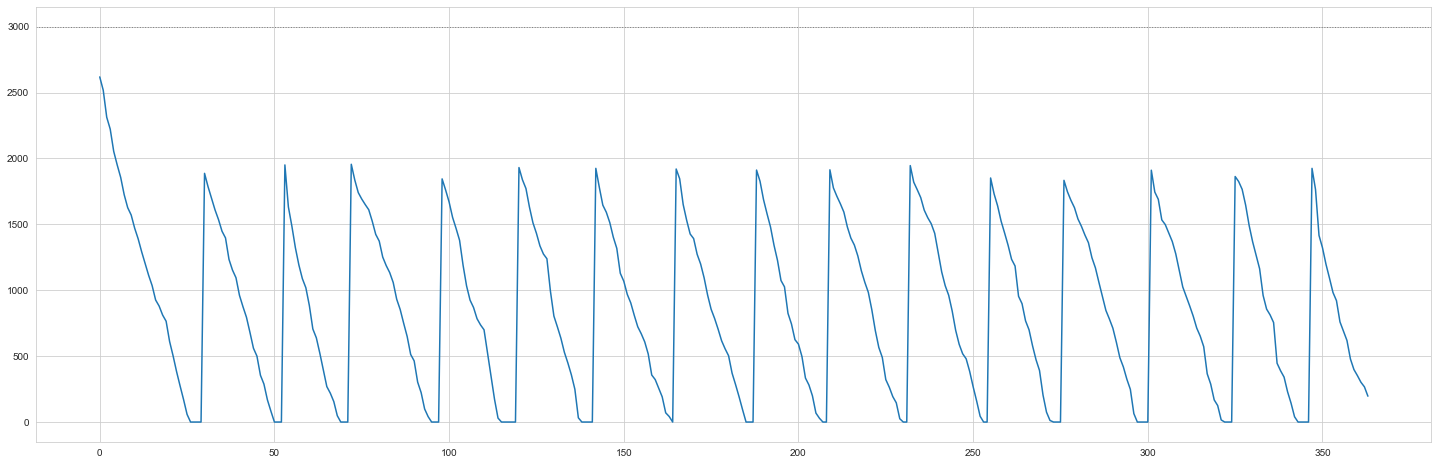

In [111]:
data = cc_monte_carlo(2000, 700)
#reorder quantity of 2000 and inventory level of 700

plt.figure(figsize=(25,8))
plt.plot(data['inv_level'])
plt.axhline(3000, linewidth=1, color="grey", linestyle=":")
plt.show()

In [112]:
#Number of orders

len(data['orders'])

15

In [113]:
def cc_mc_simulation(q, r, num_simulations):
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = cc_monte_carlo(q, r)
        # Calculating the profit
        profit = calculate_profit(data)
        profit_list.append(profit)
        # Calculating the orders lost
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders/total_demand)

    return profit_list, orders_lost_list

In [127]:
p_list2, o_list2 = cc_mc_simulation(2000, 700, 100)
print([np.mean(p_list), np.std(p_list)])

[104252.51, 2949.8963286698736]


Text(0.5, 1.02, 'Profit Distribution: Mean = 104,252 ')

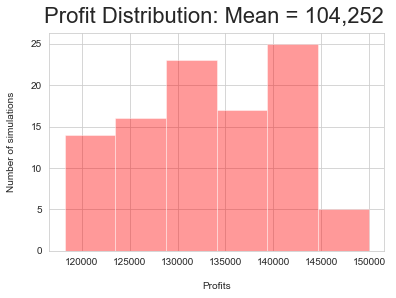

In [128]:
sns.distplot(
    p_list2,
    kde=False,
    color='red'
)
plt.xlabel("Profits", labelpad=15)
plt.ylabel("Number of simulations", labelpad=15)
plt.title("Profit Distribution: Mean = 104,252 ", y=1.02, fontsize=22)

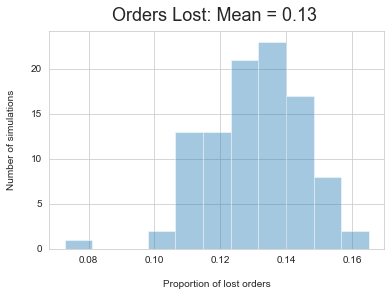

In [130]:
sns.distplot(
    o_list2,
    kde=False
)

plt.xlabel("Proportion of lost orders", labelpad=15)
plt.ylabel("Number of simulations", labelpad=15)
plt.title("Orders Lost: Mean = 0.13 ", y=1.02, fontsize=18)
plt.show()

## Profit Optimization with the Continous Review Model

By performing a grid search between a range of values for the reorder value and order quantity points, a combination that optimizes the expected profit  can be worked out. 

The model below performs simulations for order quantities from 1000 to 3000 and the re-order point between 500 and 1100. The plot seems to display a concave function signifying a maximum point for profit.


In [118]:
def continous_review(q_guess, r_guess):
    q_low = q_guess - 1000 #lower limit of order quantity
    q_high = q_guess + 1000 #upper limit of order quantity
    q_range = [i for i in range(int(q_low), int(q_high), 50)]

    r_low = r_guess - 300 #lower limit of re-order point 
    r_high = r_guess + 300 #upper limit of re-order point
    r_range = [i for i in range(int(r_low), int(r_high), 50)]

    review_dict = {}

    for q in q_range:
        for r in r_range:
            p_list, o_list = cc_mc_simulation(q, r,100)
            review_dict[(q, r)] = (
                np.mean(p_list), np.std(p_list), np.mean(o_list))

    return review_dict

#function that returns dictionary with expected profits for each pair of values

In [119]:
cc_review = continous_review(2000, 700)

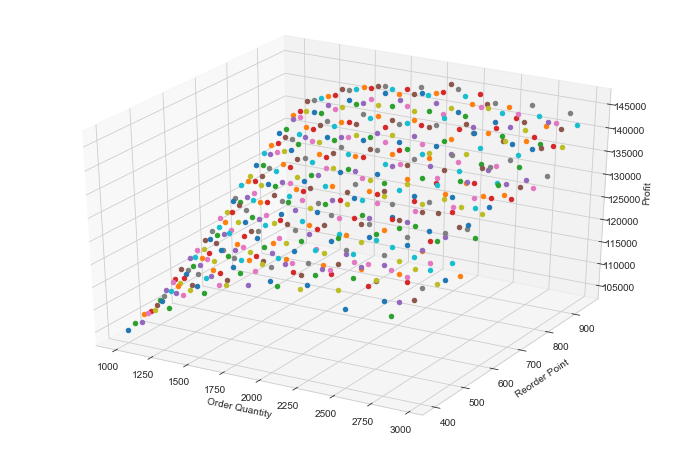

In [122]:
#3D representation of the simulation

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

for key, val in cc_review.items():
    ax.scatter(key[0], key[1], val[0], marker = 'o')

ax.set_xlabel('Order Quantity')
ax.set_ylabel('Reorder Point')
ax.set_zlabel('Profit')

plt.show()

In this scenario for Product 1, based on the simulations, a maximum profit of $145,331 for the order quantity of 2100 and the re-order point of 950 was derived.

Using this policy, the table below lists out the optimal reorder points, optimal order quantity, the expected annual profits and the proportion of orders lost over the period of the year for each of the products.

In [124]:
idx = ['Order Quantity', 'Reorder Point', 'Expected Profit', 'Profit Standard Deviation', 'Proportion of Lost Orders']

prod_review_2 = max(cc_review.items(), key=operator.itemgetter(1))

df_cc_review =  pd.DataFrame({'Product 1': [prod_review_2[0][0], prod_review_2[0][1], prod_review_2[1][0], prod_review_2[1][1], prod_review_2[1][2]]})
df_cc_review = df_cc_review.set_index(pd.Index(idx))
df_cc_review

,Product 1
Order Quantity,2100.000000
Reorder Point,950.000000
Expected Profit,145331.151025
Profit Standard Deviation,7870.804468
Proportion of Lost Orders,0.041804


In [125]:
df_product_review

,Product 1
Order-point M,3150.000000
Expected Profit,110846.690000
Profit Standard Deviation,3236.885539
Proportion of Lost Orders,0.061800


## Final Conclusion

As seen from the tables above we can see in this case the Continuous Review policy outperforms the Periodic Review policy in terms of the expected profits for each product and proportion of lost orders.

However, both the continuous and periodic review policy have their advantages. Periodic review policy has a fixed review period which allows the organization to better forecasts the orders made over a period of time. Whereas the continuous review policy keeps the order size constant and gives flexibility in terms of the times to place the order. 

The expected profits is dependent on different costs (holding, ordering and other costs) that are different for every product and organization. The right inventory management model depends on the impact of these cost and and the demand distribution of the product.



### [GitHub Link](https://github.com/Master-of-Business-Analytics/Code_repository/tree/master/Inventory%20managment)
All of the graphs and code can be found in the MBAN GitHub repository, feel free to download it and modify the numbers for your use case.




## References
[1] Anderson, Sweeney, Williams, Camm, Cochran, Fry, Ohlmann. An Introduction to Management Science: Quantitative approaches to Decision Making. 14th Edition, 2015. Cengage Learning. pp. 457–478.

[2] Nagpurkar, M. (2020, April 2). Inventory Management using Python. Retrieved June 3, 2020, from https://towardsdatascience.com/inventory-management-using-python-17cb7ddf9314